Merged training dataset saved.
Test Accuracy: 66.73%
Confusion Matrix:
[[  0   0   3   4   0   0   0]
 [  0   2  24  14   2   0   0]
 [  0   0 248  91   3   1   0]
 [  0   0  74 348  32   0   0]
 [  0   0   6  75  84   0   0]
 [  0   0   0   9   6  12   0]
 [  0   0   0   1   1   0   0]]


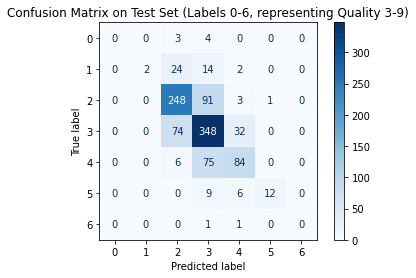

Predictions saved to ./baseline_winequality_predictions_rf.csv


In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import random
import os
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

##########################
# 1. Load and Merge Training Data
##########################

# Read the red wine training data
try:
    red_train = pd.read_csv('./winequality-red_train.csv', delimiter=',')
except Exception as e:
    print(f"Error reading winequality-red_train.csv: {e}")
    exit(1)

# Read the white wine training data
try:
    white_train = pd.read_csv('./winequality-white_train.csv', delimiter=',')
except Exception as e:
    print(f"Error reading winequality-white_train.csv: {e}")
    exit(1)

# Add a 'wine_type' column for labeling final output (0 for red, 1 for white)
red_train['wine_type'] = 0
white_train['wine_type'] = 1

# Merge the training datasets
merged_train = pd.concat([red_train, white_train], ignore_index=True)

# (Optional) Save the merged training data for reference.
merged_train.to_csv('./winequality_merged_train.csv', index=False)
print("Merged training dataset saved.")

##########################
# 2. Prepare Data for RandomForestClassifier with Normalization
##########################

# Drop the 'wine_type' column from features since it's not used for prediction.
# The target column is 'quality'.
X = merged_train.drop(columns=['quality', 'wine_type'])
y = merged_train['quality']

# Remap quality ratings from [3, 9] to [0, 6]
y = y - 3

# Initialize the scaler and fit it on the training features.
scaler = StandardScaler()
# Fit the scaler and convert the normalized data back to a DataFrame to preserve feature names.
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Capture the order of feature names (without wine_type) for use in prediction.
training_columns = list(X.columns)

# (Optional) Split into training and validation (test) sets.
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.2, random_state=seed)

##########################
# 3. Train the RandomForestClassifier
##########################

# Initialize and train the RandomForestClassifier.
# Note: RandomForestClassifier automatically learns the classes present.
rf_clf = RandomForestClassifier(n_estimators=188, random_state=seed)
rf_clf.fit(X_train, y_train)

# Evaluate on the validation (test) set.
y_val_pred = rf_clf.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")  # Print accuracy as a percentage

# Compute the confusion matrix.
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(cm)

# Display the confusion matrix using matplotlib.
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set (Labels 0-6, representing Quality 3-9)")
plt.show()

##########################
# 4. Predict on Goal Data and Merge Results
##########################

def predict_and_save_combined_rf(model, scaler, training_columns, files, output_csv):
    """
    For each goal CSV, load the data, drop unnecessary columns ('quality' and 'wine_type'),
    normalize the features using the pre-fitted scaler, and reorder the columns to match training_columns.
    Then predict the quality using the trained model and merge all predictions into a single CSV.

    The final output includes an ID that retains the wine type.
    Note: The model predicts labels 0 to 6; we add 3 to convert back to the original scale (3 to 9).
    """
    results = []

    for file_path, wine_type_str in files:
        try:
            data = pd.read_csv(file_path, delimiter=',')
        except Exception as e:
            print(f"Error reading CSV file {file_path}: {e}")
            continue

        # Drop the 'quality' column if it exists (goal files may have an empty quality column)
        if 'quality' in data.columns:
            data = data.drop(columns=['quality'])

        # Drop the 'wine_type' column if present.
        if 'wine_type' in data.columns:
            data = data.drop(columns=['wine_type'])

        # Ensure the data has the same independent variables as training.
        missing_cols = set(training_columns) - set(data.columns)
        if missing_cols:
            print(f"Error: {file_path} is missing columns: {missing_cols}")
            continue

        # Reorder the columns to match the training set order.
        data = data[training_columns]

        # Normalize the features using the pre-fitted scaler.
        try:
            X_new_array = scaler.transform(data)
            X_new = pd.DataFrame(X_new_array, columns=training_columns, index=data.index)
        except Exception as e:
            print(f"Error normalizing data from {file_path}: {e}")
            continue

        # Predict wine quality using the trained model.
        predictions = model.predict(X_new)

        # Append predictions with an ID that includes the wine type.
        # Convert predictions back to original scale by adding 3.
        results.extend([
            {'ID': f"{wine_type_str}_{i+1}", 'quality': int(pred) + 3}
            for i, pred in enumerate(predictions)
        ])

    # Save combined predictions to CSV.
    results_df = pd.DataFrame(results)
    try:
        results_df.to_csv(output_csv, index=False)
        print(f"Predictions saved to {output_csv}")
    except Exception as e:
        print(f"Error saving predictions to CSV: {e}")

# Define goal files and their wine types.
goal_files = [
    ("./winequality-red_goal.csv", "red"),
    ("./winequality-white_goal.csv", "white")
]

# Make predictions on the goal datasets and save to a single CSV.
predict_and_save_combined_rf(rf_clf, scaler, training_columns, goal_files, "./baseline_winequality_predictions_rf.csv")
